<div style='background-image: url("../../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> SBP-SAT finite difference method for the 2D elastic wave equation in velocity-stress form </div>
        </div>
    </div>
</div>

This notebook is based on the paper [Dynamic earthquake rupture simulations on nonplanar faults embedded in 3D geometrically complex, heterogeneous Earth models](https://pangea.stanford.edu/~edunham/publications/Duru_Dunham_FD3d_JCP16.pdf), and on the theory of summation-by-parts (SBP) finite difference methods and weak implementation of boundary conditions using the simultaneous-approximation-term (SAT).


##### Authors:
* Kenneth Duru

---

## Basic Equations ##

Consider the 2D elastic wave equation in a heterogeneous rectangular, $(x,y) \in [0, L_x]\times [0, L_y]$, isotropic elastic solid 

\begin{align}
\rho(x,y)\frac{\partial u(x, y,t)}{\partial t} -\frac{\partial \sigma_{xx}(x,y,t)}{\partial x} -\frac{\partial \sigma_{xy}(x,y,t)}{\partial y} & = 0,\\
\rho(x,y)\frac{\partial v(x,y,t)}{\partial t} -\frac{\partial \sigma_{xy}(x,y,t)}{\partial x} -\frac{\partial \sigma_{yy}(x,y,t)}{\partial y} & = 0, \\
S \begin{pmatrix}
\frac{\partial \sigma_{xx}(x,y,t)}{\partial t}\\
\frac{\partial \sigma_{yy}(x,y,t)}{\partial t}\\
\frac{\partial \sigma_{xy}(x,y,t)}{\partial t}
\end{pmatrix}
-\begin{pmatrix}
\frac{\partial u(x,y,t)}{\partial x}\\
\frac{\partial v(x,y,t)}{\partial y}\\
\frac{\partial v(x,y,t)}{\partial x} + \frac{\partial u(x,y,t)}{\partial y}
\end{pmatrix}&=0
\end{align}

with $\rho(x,y)$ the density, $S$ is the compliance matrix with $S = C^{-1}$, and $C = C^T > 0$ is the matrix of elastic coefficients defined 
\begin{align}
C= \begin{pmatrix}
2\mu + \lambda & \lambda & 0 \\
 \lambda & 2\mu + \lambda & 0 \\
0 & 0 & \mu \\
\end{pmatrix}.
\end{align}

Here, $\lambda$ and $\mu$ are the Lame parameters satisfying $\mu >0$, $2\mu + \lambda > 0$. 
The elastic wave equation supports two families of waves p-wave and s-wave defined by the wavespeeds $c_p = \sqrt{\left(2\mu + \lambda\right)/\rho}$, $c_s = \sqrt{\mu/\rho}$. At the boundaries $ x = 0, x = L_x$, $ y = 0, y = L_y$ we pose the general well-posed linear boundary conditions

\begin{equation}
\begin{split}
B_{p0x}(u, \sigma_{xx}, Z_p, r_0)=\frac{Z_p}{2}\left({1-r_0}\right){u} -\frac{1+r_0}{2} {\sigma_{xx}} = 0, \quad B_{s0x}(v, \sigma_{xy}, Z_s, r_0)=\frac{Z_s}{2}\left({1-r_0}\right){v} -\frac{1+r_0}{2} {\sigma_{xy}} = 0, \quad x = 0, \\
 B_{pLx}(u, \sigma_{xx}, Z_p, r_n)=\frac{Z_p}{2}\left({1-r_n}\right){u} +\frac{1+r_n}{2} {\sigma_{xx}} = 0, \quad B_{sLx}(v, \sigma_{xy}, Z_s, r_n)=\frac{Z_s}{2}\left({1-r_n}\right){v} +\frac{1+r_n}{2} {\sigma_{xy}} = 0, \quad x = L_x, \\
 B_{p0y}(v, \sigma_{yy}, Z_p, r_0)=\frac{Z_p}{2}\left({1-r_0}\right){v} -\frac{1+r_0}{2} {\sigma_{yy}} = 0, \quad B_{s0y}(u, \sigma_{xy}, Z_s, r_0)=\frac{Z_s}{2}\left({1-r_0}\right){u} -\frac{1+r_0}{2} {\sigma_{xy}} = 0, \quad y = 0, \\
 B_{pLx}(v, \sigma_{yy}, Z_p, r_n)=\frac{Z_p}{2}\left({1-r_n}\right){v} +\frac{1+r_n}{2} {\sigma_{yy}} = 0, \quad B_{sLy}(u, \sigma_{xy}, Z_s, r_n)=\frac{Z_s}{2}\left({1-r_n}\right){u} +\frac{1+r_n}{2} {\sigma_{xy}} = 0, \quad y = L_y, \\
 \end{split}
\end{equation}

with  the elastic wave impedances $Z_p = \rho c_p$, $Z_s = \rho c_s$, and the reflection coefficients $r_0$, $r_n$ being real numbers and  $|r_0|, |r_n| \le 1$. 

Note that,  while  $r_j = -1$ yields soft wall, $r_j = 0$  yields  an absorbing boundary, and  with $r_j = 1$  we have a hard wall boundary condition. 

In the coming analysis, we will set $F(x,y,t) =0$ to simplify the algebra.

Introduce the mechanical energy defined by
\begin{equation}
E(t) = \int_0^{L_y}\int_0^{L_x}{\left(\frac{\rho(x, y)}{2} \left(u^2(x, y, t) + v^2(x, y, t)\right) 
+ \frac{1}{2} 
\begin{pmatrix}
 \sigma_{xx}(x,y,t)\\
\sigma_{yy}(x,y,t)\\
 \sigma_{xy}(x,y,t)
\end{pmatrix}^T
S 
\begin{pmatrix}
 \sigma_{xx}(x,y,t)\\
\sigma_{yy}(x,y,t)\\
 \sigma_{xy}(x,y,t)
\end{pmatrix}
\right) dxdy},
\end{equation}

where $E(t)$ is the sum of the kinetic energy and the strain energy.
We have 

\begin{equation}
\frac{d E(t)}{dt} = BT_x + BT_y \le 0,
\end{equation}

where

\begin{align}
BT_x = \int_0^{L_y}\left(\left(u(L_x, y, t)\sigma_{xx}(L_x, y, t) - u(0, y, t)\sigma_{xx}(0, y, t)\right) + \left(v(L_x, y, t)\sigma_{xy}(L_x, y, t) - v(0, y, t)\sigma_{xy}(0, y, t)\right) \right)dy\\
BT_y = \int_0^{L_x}\left(\left(v(x, L_y, t)\sigma_{yy}(x, L_y, t) - v(x, 0, t)\sigma_{yy}(x, 0, t)\right) + \left(u(x, L_y, t)\sigma_{xy}(x, L_y, t) - u(x, 0, t)\sigma_{xy}(x, 0, t)\right) \right)dx
\end{align}

From the boundary conditions, it is easy to check that $ BT_x \ge 0$, $ BT_y \ge 0$  for all $|r_0|, |r_n| \le 1$. This energy loss through the boundaries is what the numerical method should emulate. 

1) Discretize the spatial domain:
\begin{align}
x_i = (i-1)\Delta{x}, \quad i = 1, 2, \dots, N_x, \quad \Delta{x} = \frac{L_x}{N_x-1}, \quad y_j = (j-1)\Delta{y}, \quad j = 1, 2, \dots, N_y, \quad \Delta{y} = \frac{L_y}{N_y-1}.
\end{align}

Denote a nodal approximation of the solution on the grid by $\mathbf{v}(t) = [v_{i,j}(t)]$, where $v_{i,j}(t) \approx v(x_i, y_j, t)$.


2) Introduce $\mathbf{D}$, a one space dimensional finite difference matrix satisfying the summation-by-parts property:

\begin{align}
\mathbf{D} = \mathbf{H}^{-1}\mathbf{Q}, \quad \mathbf{Q} + \mathbf{Q} = \left(\boldsymbol{e}_{N}\boldsymbol{e}_{N}^T -\boldsymbol{e}_{1}\boldsymbol{e}_{1}^T\right), \quad \mathbf{H}^T = \mathbf{H} > 0,
\end{align}

where, $\boldsymbol{e}_{0} = [1, 0, \dots,  0 ]^T, \quad  \boldsymbol{e}_{L} = [ 0, 0, \dots,  1 ]^T$ and $\mathbf{H}$ defines a dicrete norm. We consider only diagonal norm SBP operators with $H_{jj} = h_j > 0$, and define the quadrature rule

\begin{equation}
 \sum_{i = 1}^{N} f(x_j)h_j \approx \int_{0}^{L}f(x) dx, \quad h_j = \alpha_j \Delta{x},
\end{equation}
where $\alpha_j > 0$ are dimensionless quadrature weights.

The operator can be easily extended to multiple dimensions using Kronecker products:
\begin{equation}
\mathbf{D}_x = \left(\mathbf{D}\otimes \mathbf{I}\right), \quad \mathbf{D}_y = \left(\mathbf{I}\otimes \mathbf{D}\right),
\end{equation}
where $\mathbf{I}$ is the identity matrix.

The second order accurate SBP operator for first derivative is:
\begin{align}
\left(\mathbf{D}_x\mathbf{v}\right)_{i,j} = \frac{v_{i+1,j}-v_{i-1, j}}{2 \Delta{x}}, \quad i = 2, 3, \cdots N_x-1, \quad
\left(\mathbf{D}_x\mathbf{v}\right)_{1,j} = \frac{v_{2,j}-v_{1,j}}{\Delta{x}},\quad
\left(\mathbf{D}_x\mathbf{v}\right)_{N_xj} = \frac{v_{N_x,j}-v_{N_x-1,j}}{\Delta{x}}.
\end{align}

\begin{align}
\left(\mathbf{D}_y\mathbf{v}\right)_{i,j} = \frac{v_{i,j+1}-v_{i, j-1}}{2 \Delta{y}}, \quad j = 2, 3, \cdots N_y-1, \quad
\left(\mathbf{D}_y\mathbf{v}\right)_{i,j} = \frac{v_{i,2}-v_{i,1}}{\Delta{y}},\quad
\left(\mathbf{D}_y\mathbf{v}\right)_{i,N_y} = \frac{v_{i, N_y}-v_{i, N_y-1}}{\Delta{y}}.
\end{align}



Note that the interior stencils are centered, with second order accuracy and the boundary stencils are one-sided and first order accurate. 

Higher order SBP operators can be found in the book: High Order Difference Methods for Time Dependent PDE, by B. Gustafsson. In this notebook we implement SBP operators with interior accuracy 2, 4 and 6. The implementation of the spatial derivative operators can be found in the file first_derivative_sbp_operators.py

To construct a stable  semi-discrete approximation we replace the spatial derivatives by the SBP operators, and add the boundary conditions as SAT-terms with special penalty weights having:

\begin{align}
\rho_{i,j}\frac{d u_{i,j}(t)}{d t} -\left(\mathbf{D}_x \boldsymbol{\sigma}_{xx}\right)_{i,j} -\left(\mathbf{D}_ y\boldsymbol{\sigma}_{xy}\right)_{i,j} & = -\left(\frac{1}{h_1^{(x)}}SAT^{(1y)}_{pi,j} +  \frac{1}{h_{N_x}^{(x)}}SAT^{(Nx)}_{pi,j} + \frac{1}{h_1^{(y)}}SAT^{(1y)}_{si,j} +  \frac{1}{h_{N_y}^{(y)}}SAT^{(Ny)}_{si,j}\right),\\
\rho_{i,j}\frac{d v_{i,j}(t)}{d t} - \left(\mathbf{D}_x \boldsymbol{\sigma}_{xy}\right)_{i,j} - \left(\mathbf{D}_y \boldsymbol{\sigma}_{yy}\right)_{i,j} & = -\left(\frac{1}{h_1^{(x)}}SAT^{(1x)}_{si,j} +  \frac{1}{h_{N_x}^{(x)}}SAT^{(Ny)}_{si,j} + \frac{1}{h_1^{(y)}}SAT^{(1y)}_{pi,j} +  \frac{1}{h_{N_y}^{(y)}}SAT^{(Ny)}_{pi,j}\right), \\
\mathbf{S}_{i,j} \begin{pmatrix}
\frac{d \sigma_{xxi,j}(t)}{d t}\\
\frac{d \sigma_{yyi,j}(t)}{d t}\\
\frac{d \sigma_{xyi,j}(t)}{d t}
\end{pmatrix}
-\begin{pmatrix}
\left(\mathbf{D}_x \mathbf{u}\right)_{i,j}\\
\left(\mathbf{D}_y \mathbf{v}\right)_{i,j}\\
\left(\mathbf{D}_x \mathbf{v}\right)_{i,j} + \left(\mathbf{D}_y \mathbf{u}\right)_{i,j}
\end{pmatrix}&= 
\begin{pmatrix}
\frac{1}{Z_{pi,j}h_1^{(x)}}SAT^{(1x)}_{pi,j} -  \frac{1}{Z_{pi,j}h_{N_x}^{(x)}}SAT^{(Nx)}_{pi,j}\\
\frac{1}{Z_{pi,j}h_1^{(y)}}SAT^{(1y)}_{pi,j} -  \frac{1}{Z_{pi,j}h_{N_y}^{(y)}}SAT^{(Ny)}_{pi,j}\\
\frac{1}{Z_{si,j}h_1^{(x)}}SAT^{(1x)}_{si,j} -  \frac{1}{Z_{si,j}h_{N_x}^{(x)}}SAT^{(Nx)}_{si,j}\frac{1}{Z_{si,j}h_1^{(y)}}SAT^{(1y)}_{si,j} -  \frac{1}{Z_{si,j}h_{N_y}^{(y)}}SAT^{(Ny)}_{si,j}
\end{pmatrix}
\end{align}


where 

\begin{align}
h_i^{(x)} = \alpha_i \Delta{x}, \quad h_j^{(y)} = \alpha_j \Delta{y},
\end{align}

and $l = p, s$

\begin{align}
 SAT^{(1x)}_{li,j} =  \left \{
\begin{array}{rl}
B_{l0x}, \quad i = 1\\
  0, \quad i \ne 1
\end{array} \right.
\quad
SAT^{(Nx)}_{li,j} =  \left \{
\begin{array}{rl}
B_{lLx}, \quad i = N_x\\
  0, \quad i \ne N_x
\end{array} \right.
\end{align}

\begin{align}
 SAT^{(1y)}_{li,j} =  \left \{
\begin{array}{rl}
B_{l0y}, \quad j = 1\\
  0, \quad j \ne 1
\end{array} \right.
\quad
SAT^{(Ny)}_{li,j} =  \left \{
\begin{array}{rl}
B_{lLy}, \quad j = N_y\\
  0, \quad j \ne N_y
\end{array} \right.
\end{align}

Numerical implementation of the spatial derivatives and the boundary conditions are realized in the file rate2D.py.


Approximate the mechanical energy by the above quadrature rule, having 
\begin{align}
\mathcal{E}( t) = \sum_{i=1}^{N_x}\sum_{j=1}^{N_y}\left(\frac{\rho_{i,j}}{2} \left(u^2_{i,j}(t) + v^2_{i,j}(t)\right) 
+ \frac{1}{2} 
\begin{pmatrix}
 \sigma_{xxi,j}(t)\\
\sigma_{yyi,j}(t)\\
 \sigma_{xyi,j}(t)
\end{pmatrix}^T
S_{i,j} 
\begin{pmatrix}
 \sigma_{xxi,j}(t)\\
\sigma_{yyi,j}(t)\\
 \sigma_{xyi,j}(t)
\end{pmatrix}
\right)h_i^{(x)}h_j^{(y)} > 0.
\end{align}

The semi-discrete approximation satisfies the energy equation:
\begin{align}
\frac{d \mathcal{E}( t)}{d t} = BT_{x}(t) + BT_{y}(t) \le 0,
\end{align}

where the boundary terms $BT_{\xi}$, $\xi = x, y$, are given by

\begin{align}
BT_{x}(t) = &-\frac{1}{2}\sum_{j =1}^{N_y}\left(\left(1-r_0\right)Z_{p1,j}u_{1,j}^2(t) + \frac{\left(1+r_0\right)}{Z_{p1,j}}\sigma_{xx1,j}^2(t) +
\left(1-r_n\right)Z_{pN_x,j}u_{N_x,j}^2(t) + \frac{\left(1+r_n\right)}{Z_{pN_x,j}}\sigma_{xxN_x,j}^2(t)\right)h_j^{(y)}\\
&-\frac{1}{2}\sum_{j =1}^{N_y}\left(\left(1-r_0\right)Z_{s1,j}v_{1,j}^2(t) + \frac{\left(1+r_0\right)}{Z_{s1,j}}\sigma_{xy1,j}^2(t) +
\left(1-r_n\right)Z_{sN_x,j}v_{N_x,j}^2(t) + \frac{\left(1+r_n\right)}{Z_{sN_x,j}}\sigma_{xyN_x,j}^2(t)\right)h_j^{(y)} \le 0, \\
BT_{y}(t) = &-\frac{1}{2}\sum_{i =1}^{N_x}\left(\left(1-r_0\right)Z_{pi,1}v_{i,1}^2(t) + \frac{\left(1+r_0\right)}{Z_{pi,1}}\sigma_{yyi,1}^2(t) +
\left(1-r_n\right)Z_{pi,N_y}u_{N_x,j}^2(t) + \frac{\left(1+r_n\right)}{Z_{pi,N_y}}\sigma_{yyi,N_y}^2(t)\right)h_i^{(x)}\\
&-\frac{1}{2}\sum_{i =1}^{N_x}\left(\left(1-r_0\right)Z_{si,1}u_{i,1}^2(t) + \frac{\left(1+r_0\right)}{Z_{s1,j}}\sigma_{xyi,1}^2(t) +
\left(1-r_n\right)Z_{si,N_y}v_{i,N_y}^2(t) + \frac{\left(1+r_n\right)}{Z_{si,N_y}}\sigma_{xyi,N_y}^2(t)\right)h_i^{(x)} \le 0.
\end{align}


3) The discrete mechanical energy can never grow in time, and thus the semidiscrete numerical approximation is asymptotically stable.

4)  Time integration can be performed using any stable time stepping scheme. This notebook implements the fourth order accurate Runge-Kutta method. 

Waves are generated by adding a 'point' source to the pressure equation with 

\begin{equation}
F(x,y,t)  = \frac{1}{2\pi\sqrt{\delta_x\delta_y}}e^{ -\left(\frac{(x - x_{0})^2}{2\delta_x^2}+ \frac{(y - y_{0})^2}{2\delta_y^2}\right)}f(t),  \quad \delta_x = 2\Delta{x},  \quad \delta_y = 2\Delta{y}.
\end{equation}

**** Exercises****



In [1]:
# Parameters initialization and plotting the simulation
# Import necessary routines
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import RK4_2D

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook

In order to show in a faster way the solutions of the equations this notebook has less spatial and temporal resolution. In the case you want to increase its resolution you can modify the grid points in x and y (maintaining their proportions), the snapshot frequency, the type of model or the spatial order of accuracy. 

In [2]:
# Parameter configuration
Lx = 50.0     # length of the domain (x-axis)
Ly = 50.0     # width of the domain (y-axis)

nx = 101       # grid points in x
ny = 101       # grid points in y
nt = 201       # number of time steps

dx = Lx/nx    # spatial step in x
dy = Ly/ny    # spatial step in y

isnap = 1     # snapshot frequency

nf = 5        # number of fields
cs = 3.464    # shear wave speed
cp = 6.0      # compresional wave speed
rho = 2.6702  # density

# source parameters
x0 = 25.0        # [km]
y0 = 7.5         # [km]
t0 = 0.0         # [s]
T =  0.1         # [s]
M0 = 1000.0      # [MPa]

source_type = 'Gaussian' # 'Gaussian', 'Brune'

M = [0, 0, 1., 1., 0]

source_parameter = [x0, y0, t0, T, M0, source_type, M]

# extract Lame parameters
mu = rho*cs**2
Lambda = rho*cp**2-2.0*mu

dt = 0.5/np.sqrt(cp**2 + cs**2)*dx    # Time step

order = 4        # spatial order of accuracy

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "random"

# Initialize velocity model
Mat = np.zeros((nx, ny, 3))

if model_type == "homogeneous":
    Mat[:,:,0] += rho
    Mat[:,:,1] += Lambda
    Mat[:,:,2] += mu

elif model_type == "random":
    pert = 0.4
    r_rho = 2.0 * (np.random.rand(nx, ny) - 0.5) * pert
    r_mu = 2.0 * (np.random.rand(nx, ny) - 0.5) * pert
    r_lambda = 2.0 * (np.random.rand(nx, ny) - 0.5) * pert
    
    Mat[:,:,0] += rho*(1.0 + r_rho)
    Mat[:,:,1] += Lambda*(1.0 + r_lambda)
    Mat[:,:,2] += mu*(1.0 + r_mu)
    
# Initialize pressure at different time steps and the second
# derivatives in each direction
F = np.zeros((nx, ny, nf))
Fnew = np.zeros((nx, ny, nf))

X = np.zeros((nx, ny))
Y = np.zeros((nx, ny))
              
p = np.zeros((nx, ny))

for i in range(0, nx):
    for j in range(0, ny):
        X[i, j] = i*dx
        Y[i,j] = j*dy

v = 0.25
p = np.sqrt(F[:,:,0]**2 + F[:,:,1]**2)

# Receiver locations
rx = np.array([15, 20, 25, 30, 35])
ry = np.array([0, 0, 0, 0, 0])

irx = np.array([15, 20, 25, 30, 35])
iry = np.array([0, 0, 0, 0, 0])

for i in range(len(rx)):
    irx[i] = (np.ceil(rx[i]*dx))
    iry[i] = (np.ceil(ry[i]*dy))

seisvx = np.zeros((len(irx), nt))
seisvy = np.zeros((len(irx), nt))

<IPython.core.display.Javascript object>


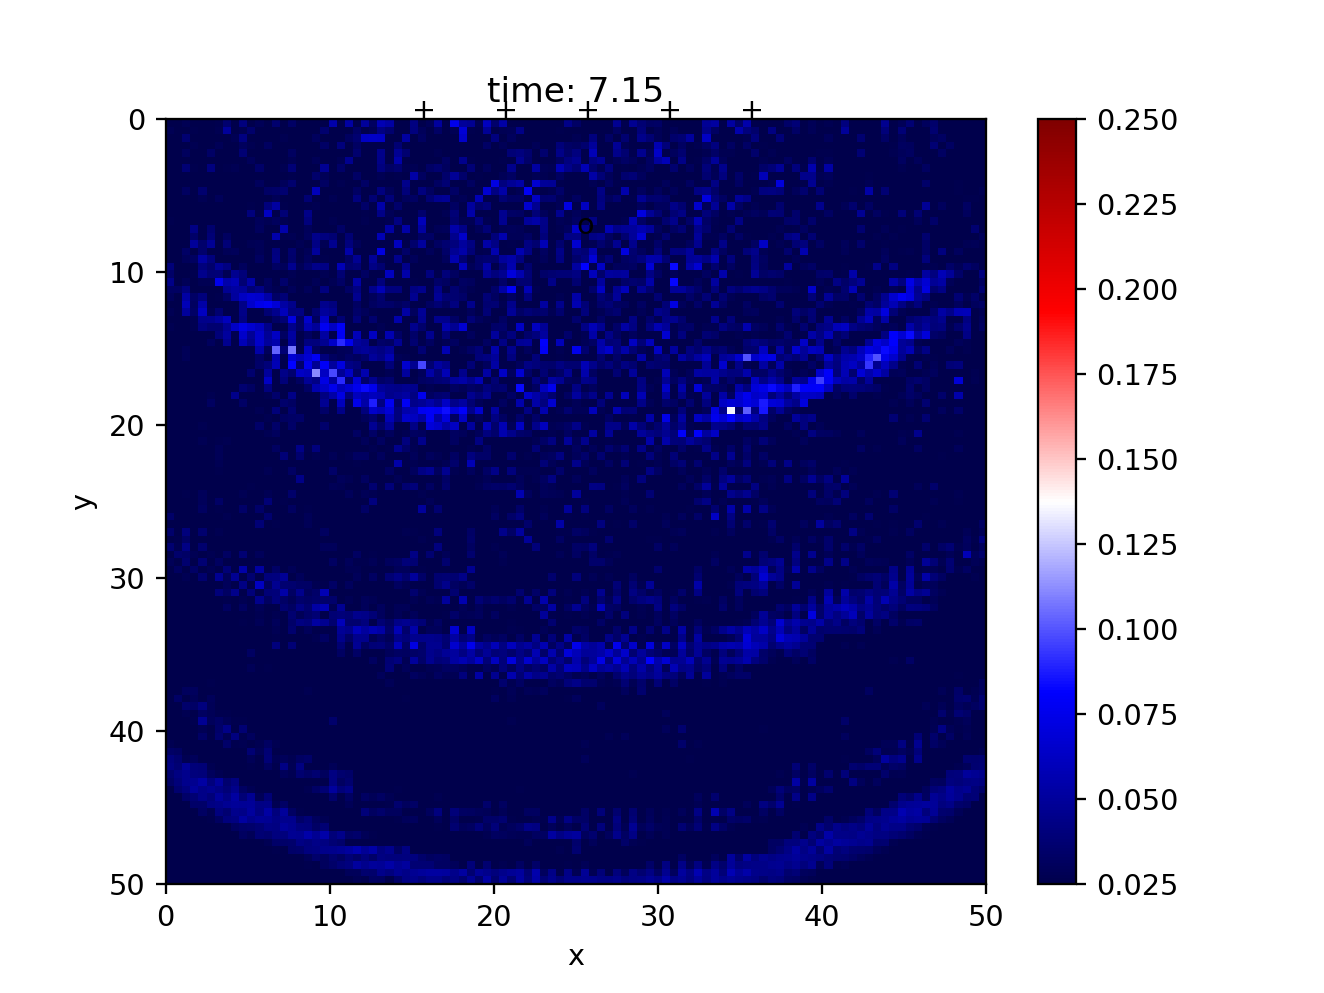

<IPython.core.display.Javascript object>


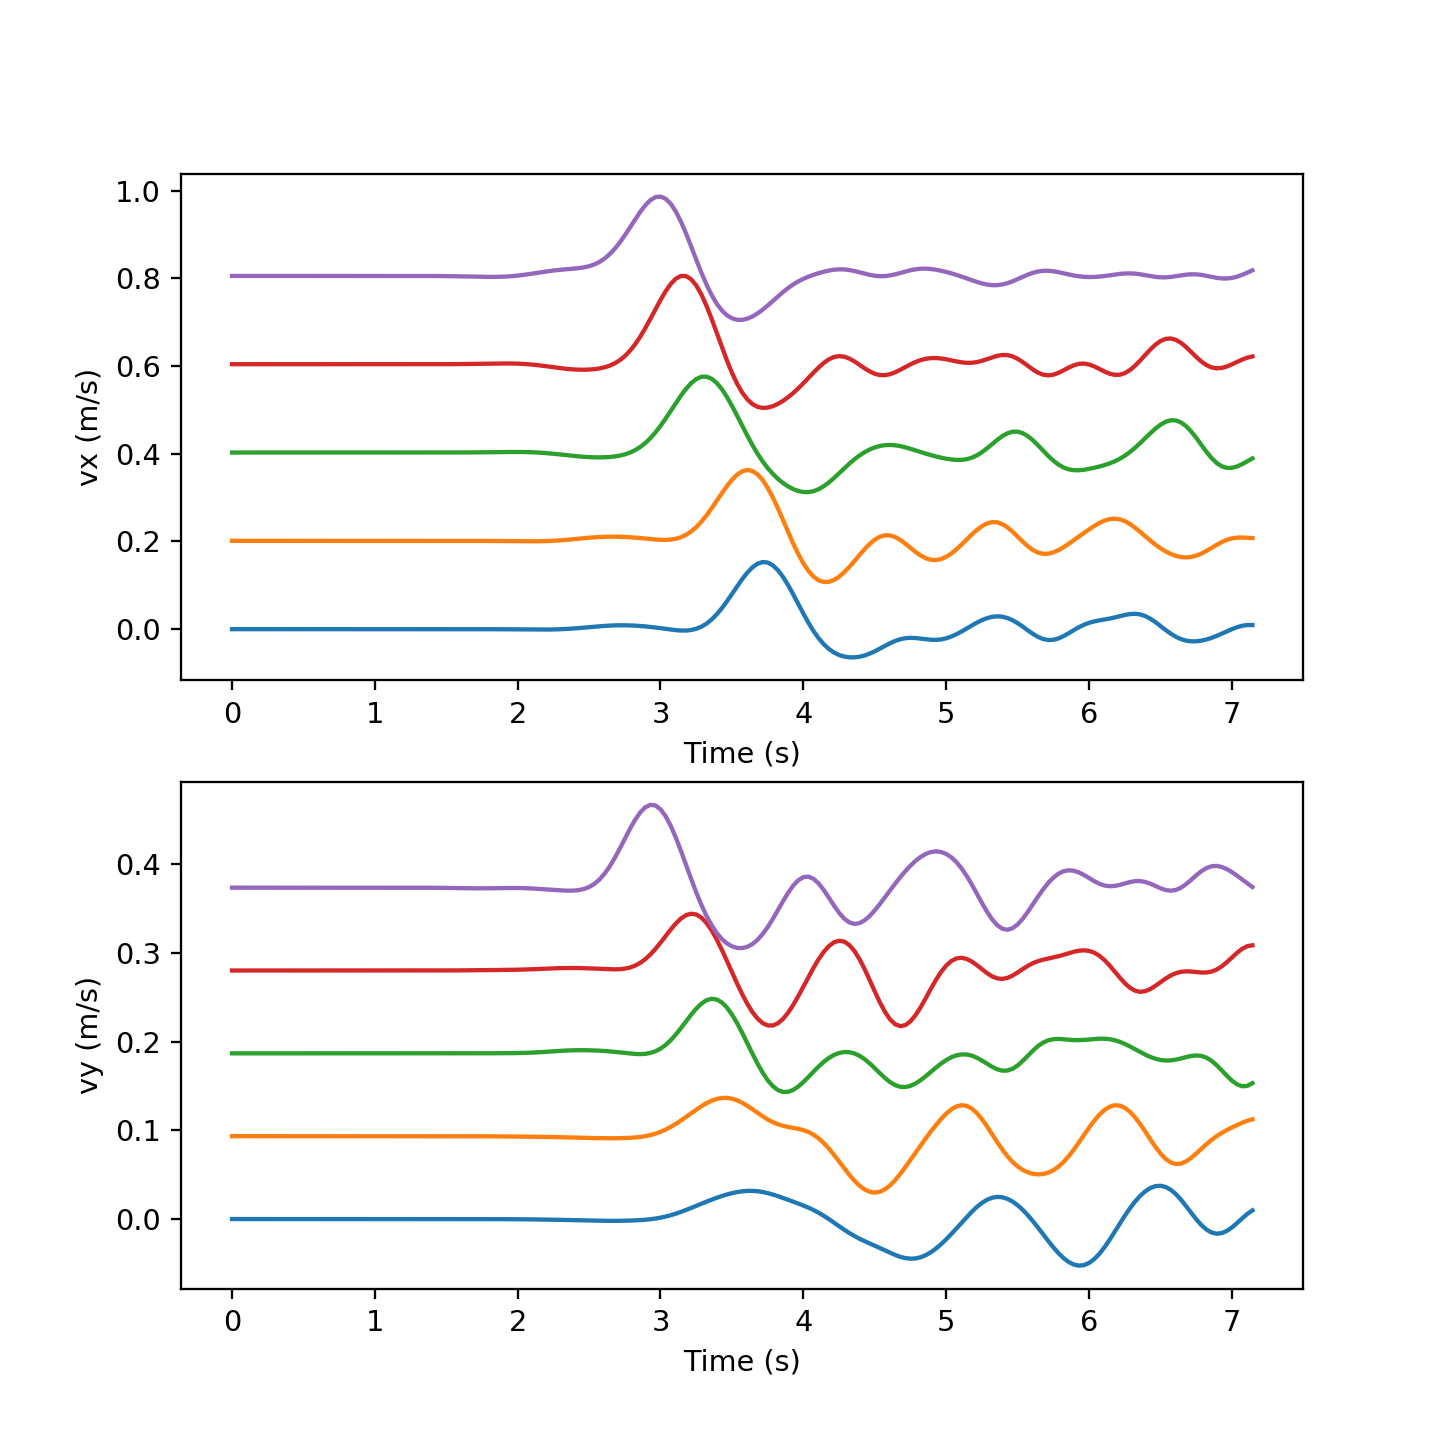

In [3]:
#  Simulation
image = plt.imshow(p.transpose(), aspect='auto',extent=[0,Lx,Ly,0]
          ,cmap = 'seismic', vmin=0.1*v, vmax=+v, animated=True, 
          interpolation='none')

# Plot the receivers
for x, y in zip(rx, ry):
    plt.text(x, y, '+')

plt.text(x0, y0, 'o')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.show()
# Boundary reflection coefficients: 0<= r[j] <= 1
r = np.array([0.,0.,1.,0.])


# required for seismograms
ir = np.arange(len(irx))

#################################################

# Time-stepping 
for it in range(nt):
    
    t = it*dt
    #4th order Runge-Kutta 
    RK4_2D.elastic_RK4_2D(Fnew, F, Mat, X, Y, t, nf, nx, ny, dx, dy, dt, order, r, source_parameter)

    # update fields
    F = Fnew
    
    #extract particle velocity for visualization
    p = np.sqrt(F[:,:,0]**2 + F[:,:,1]**2)

    # update time
    t = it*dt
    
    # Plot every isnap-th iteration
    if it % isnap == 0:                    # you can change the speed of the plot by increasing the plotting interval
        plt.title("time: %.2f" % t)
        image.set_data(p.transpose())
        plt.gcf().canvas.draw()
        #plt.show()
        #print(it)
    
    # Save seismograms
    seisvx[ir, it] = F[irx[ir], iry[ir], 0]
    seisvy[ir, it] = F[irx[ir], iry[ir], 1]
    
plt.ioff()
plt.figure(figsize=(7, 7))

plt.subplot(211)
ymax = seisvx.ravel().max()
time = np.arange(nt) * dt
for ir in range(len(seisvx)):
    plt.plot(time, seisvx[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('vx (m/s)')

plt.subplot(212)
ymax = seisvy.ravel().max()
for ir in range(len(seisvy)):
    plt.plot(time, seisvy[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('vy (m/s)')

plt.show()